In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
sys.path.append('/home/manu/TFG_repo/scripts')

In [3]:
from config import data_dir
from analysis_functions import *
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [4]:
temp, pres, date, lat, lon = load_time_series('AGL_1_SB56.h5')

## AGL_1_SB56 

#### Plot all thermistors time series to find weird behaviour

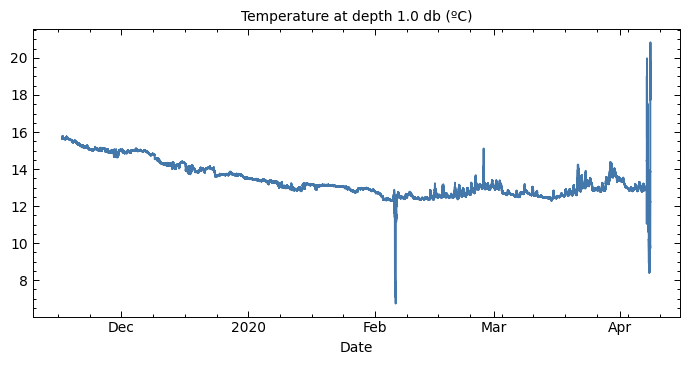

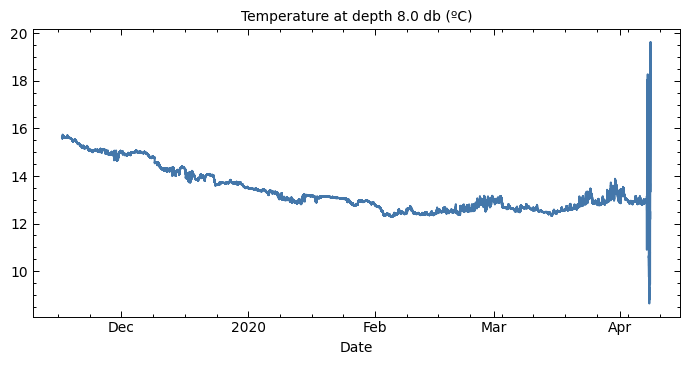

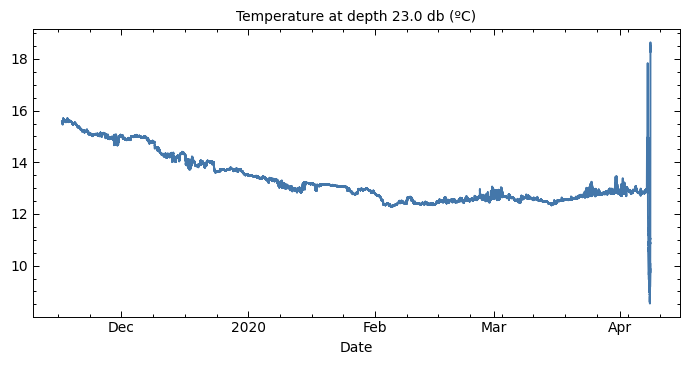

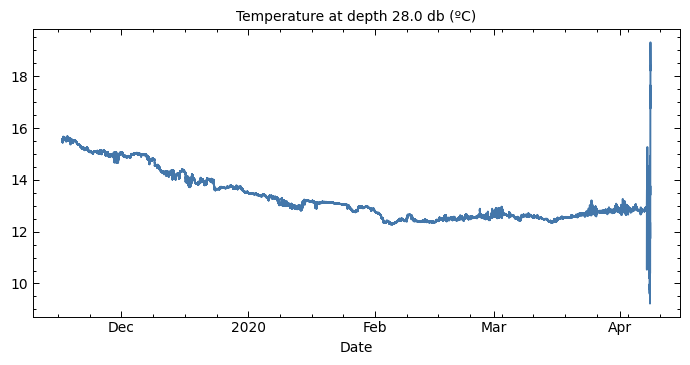

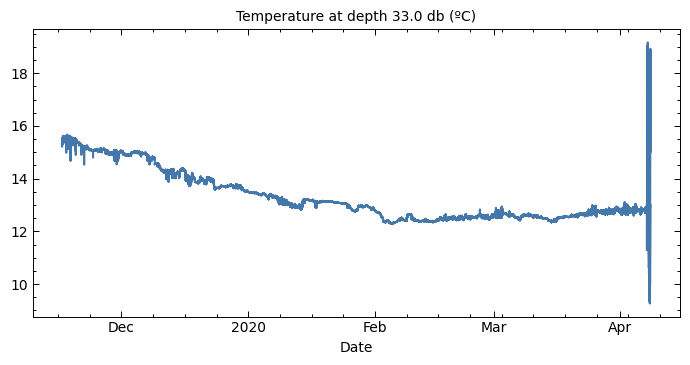

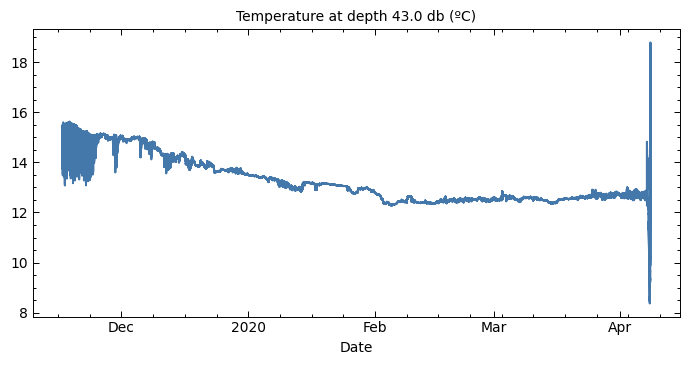

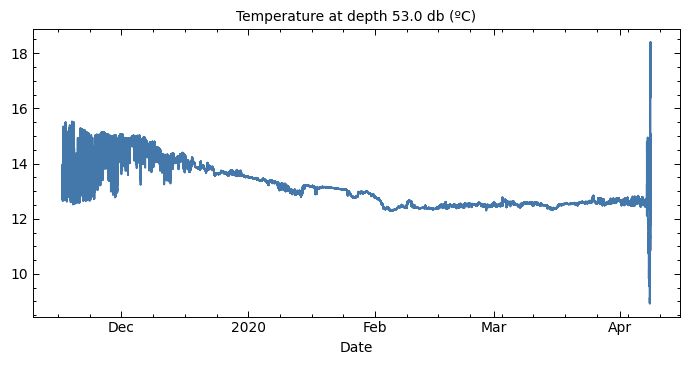

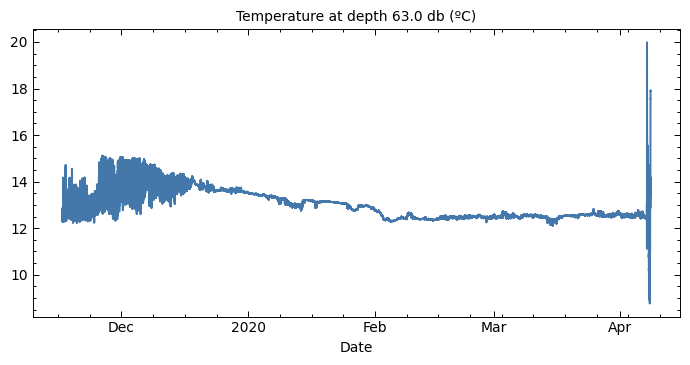

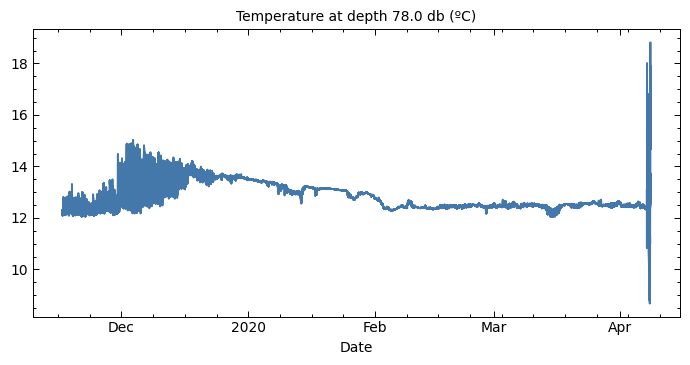

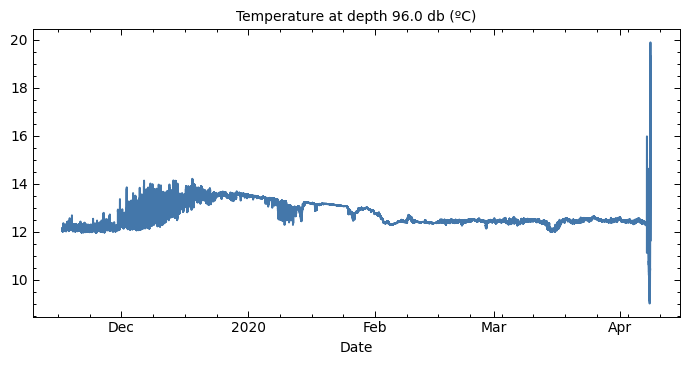

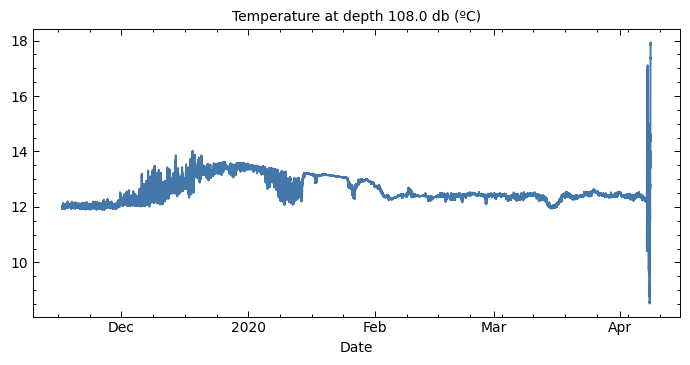

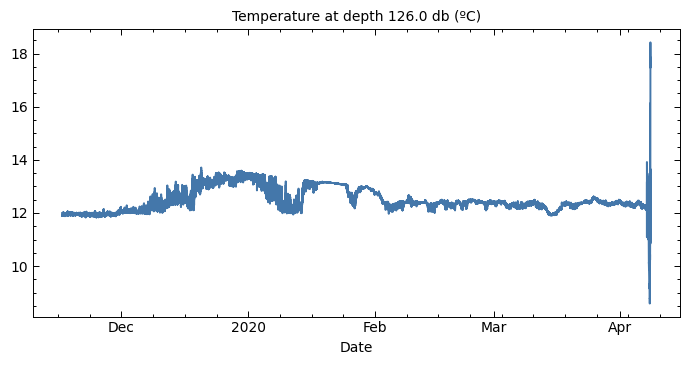

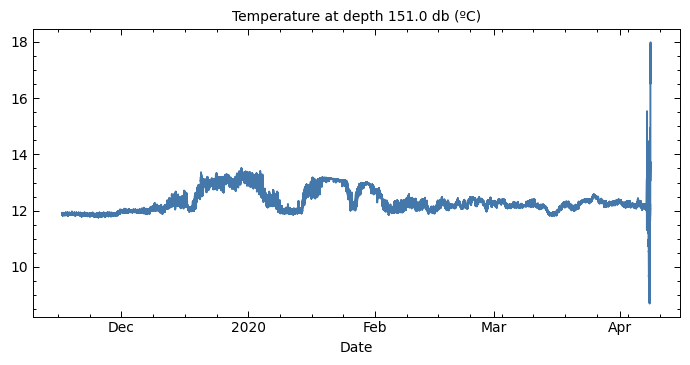

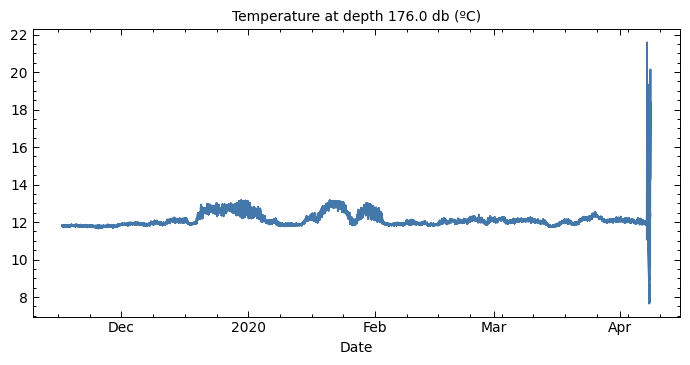

In [10]:
for i in range(len(pres)):
    plot_thermistor_series(temp, pres, date, i)

Weird behaviour at the end of all series. Due to the lifting of the thermistors out of the water. Crop this.

In [28]:
date_1 = datetime(2020, 4, 7, 11)

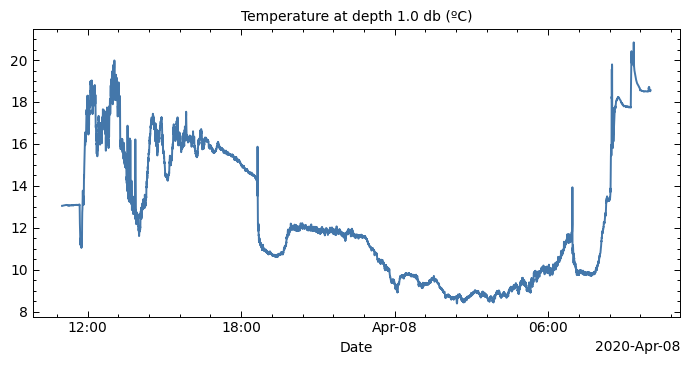

In [29]:
plot_thermistor_series(temp, pres, date, 0, lims=[date_1, -1])

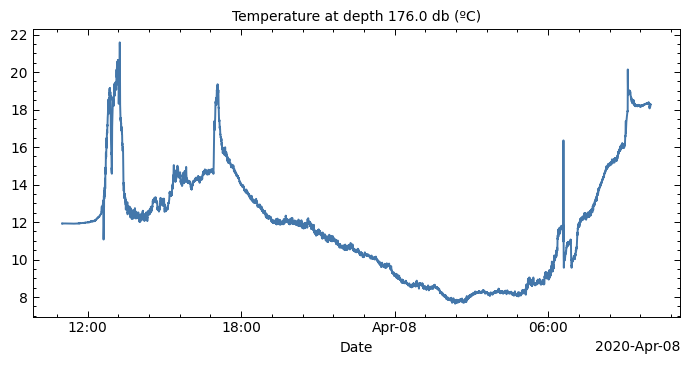

In [30]:
plot_thermistor_series(temp, pres, date, 13, lims=[date_1, -1])

In [32]:
iloc = date_to_iloc(date, date_1)
print('Hay que cortar la serie temporal en la medida {}'.format(iloc))

Hay que cortar la serie temporal en la medida 2471040


#### Caida de temperatura brusca a principios de febrero en el termistor a 1 db

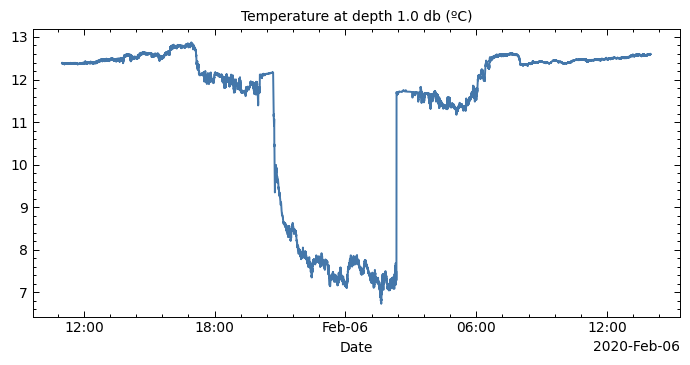

In [6]:
date_1 = datetime(2020, 2, 5, 11)
date_2 = datetime(2020, 2, 6, 14)
plot_thermistor_series(temp, pres, date, 0, lims=[date_1, date_2])

De momento recortamos esta zona de la serie temporal. Podría asumirse que la temperatura en la superficie apenas cambia y darles un valor a mano. Se podrá explorar más adelante.

In [7]:
date_1_mask = datetime(2020, 2, 5, 11)
date_2_mask = datetime(2020, 2, 6, 14)
iloc_mask_1 = date_to_iloc(date, date_1_mask)
iloc_mask_2 = date_to_iloc(date, date_2_mask)

mask_array = np.zeros_like(date)
mask_array[iloc_mask_1:iloc_mask_2] += 1


Hay que de alguna manera generar un mask para las entradas entre iloc_mask_1 e iloc_mask_2.

### Aumento brusco de temperatura a finales de febrero

In [119]:
date_3 = datetime(2020, 2, 27)
date_4 = datetime(2020, 2, 28, 12)

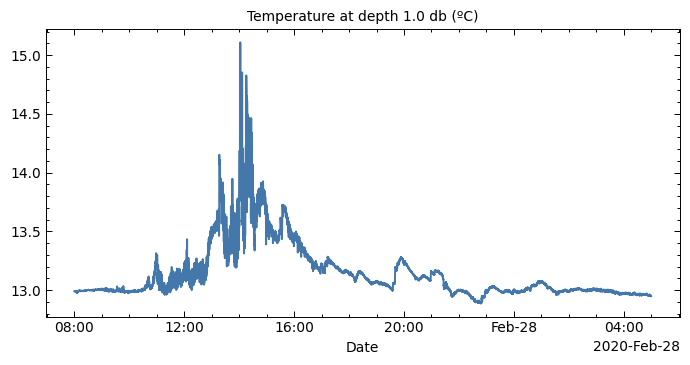

In [117]:
plot_thermistor_series(temp, pres, date, 0, lims=[date_3, date_4])

El salto puede deberse a que, otra vez, el termistor sale del agua por alguna causa. Esta vez es al mediodía por lo que la temperatura es mayor fuera del agua que dentro. Igual que antes, hacer un mask a estos valores.

In [123]:
date_3_mask = datetime(2020, 2, 27, 6)
date_4_mask = datetime(2020, 2, 28, 5)
iloc_mask_3 = date_to_iloc(date, date_3_mask)
iloc_mask_4 = date_to_iloc(date, date_4_mask)
mask_array[iloc_mask_3:iloc_mask_4] += 1

### Picos de temperatura en superficie a finales de marzo

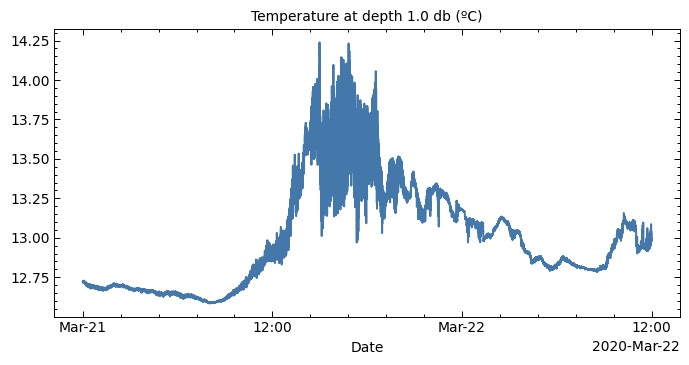

In [126]:
date_5 = datetime(2020, 3, 21)
date_6 = datetime(2020, 3, 22, 12)
plot_thermistor_series(temp, pres, date, 0, lims=[date_5, date_6])

Es muy probable que estas oscilaciones se deban a algún evento meteoroógico, o ¿al paso de corrientes en superficie? No ignorar de momento. Comparar con los sensores meteorológicos y de corrientes.

### Movidas para comparar dates

In [71]:
from gen_time_series_better import datenum_to_epoch
from datetime import timezone

In [47]:
datafile1 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE37' / 'SBE37346520190409.mat'
datafile2 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE37' / 'SBE37567420190409.mat'
datafile3 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE56' / 'AGL_SBE05600218_2019-04-09.mat'

In [52]:
up_37_mat = np.squeeze(loadmat(datafile2)['dates'])
dwn_37_mat = np.squeeze(loadmat(datafile1)['dates'])
date_56_mat = np.squeeze(loadmat(datafile3)['dates'])

up_37_epoch = list(map(datenum_to_epoch, up_37_mat))
dwn_37_epoch = list(map(datenum_to_epoch, dwn_37_mat))
date_56_epoch = list(map(datenum_to_epoch, date_56_mat))

up_37 = np.array([datetime.fromtimestamp(i) for i in up_37_epoch])
dwn_37 = np.array([datetime.fromtimestamp(i) for i in dwn_37_epoch])
date_56 = np.array([datetime.fromtimestamp(i) for i in date_56_epoch])

In [62]:
a = np.nonzero(np.in1d(up_37, dwn_37))[0]
b = np.nonzero(np.in1d(dwn_37, up_37))[0]

In [64]:
print((up_37[a]==dwn_37[b]).any())
print(len(a)) # all values of up_37 are in dwn_37 execpt last one

True
20719


In [65]:
print(up_37[a[-1]])
print(up_37[-1])
print(dwn_37[b[-1]])
print(dwn_37[-1])

2019-04-09 08:00:00
2019-04-09 08:10:00
2019-04-09 08:00:00
2019-04-09 08:00:00


In [67]:
masked_temp = np.ma.masked_all_like(np.zeros((2, len(dwn_37) + 2)))
masked_temp[1, :-2] = dwn_37_epoch
masked_temp[0, ::2] = up_37_epoch

In [1]:
(date[1:] - date[:-1] == timedelta(days=4)).nonzero()

NameError: name 'date' is not defined

En la serie AGL_1 de SBE56, sincronizada totalmente para todos los termistores, entre la entrada 122 y la 123 el periodo es de 4 segundos. De aquí en adelante pasa a ser 5 segundos otra vez. Como la serie empieza en una hora redonda (11:00:00) y hasta la medida 122 el periodo es de 5 segundos, de la medida 123 en adelante, la hora de los SBE56 nunca coincidirá con la de los SB37, que siempre es múltiplos de 5 minutos, segundos a 0. Para solucionar esto y poder sincronizar los SBE56 y 37 podemos añadir un timedelta de 1 segundo a la serie de SBE56, ya que no vamos a estudiar fenómenos a tan altas frecuencias como para que 1 segundo de disparidad afecte gravemente.

In [2]:
from netCDF4 import Dataset

In [ ]:
filename = data_dir / 'time_series' / 'processed' / 'AGL_1_37_56'
with Dataset(filename, mode='w') as f:
    